In [1]:
import sys
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as ppt
%matplotlib inline

PROGRESS_ROOT = '/media/sf_Masterarbeit/data/AE_PROGRESS/ILSVRC2012_AE_50_progress_500_0.9_succConf0.5_failConf0.1'
SUCCESS_PATH = PROGRESS_ROOT + '/' + 'success_progress_500.npy'
FAILURE_PATH = PROGRESS_ROOT + '/' + 'failure_progress_500.npy'
SAVE_PATH_PREFIX = '/media/sf_Masterarbeit/master-thesis/report/images/progress/imagenet-ae-50-500-0.9-thresholds-0.5-0.1'

TRAINING_POINT_PORTION = 0.4
INITIAL_PARAMS = np.array([0.01, 300.0, 1.0])

In [2]:
success_curves = np.load(SUCCESS_PATH)
print('Success data: Found {0} progress curves with {1} iterations each'.format(*success_curves.shape))

failure_curves = np.load(FAILURE_PATH)
print('Failure data: Found {0} progress curves with {1} iterations each'.format(*failure_curves.shape))

NUM_TRAINING_POINTS = int(round( success_curves.shape[1] * TRAINING_POINT_PORTION ))
print('Using the first {0} points for fitting'.format(NUM_TRAINING_POINTS))

Success data: Found 100 progress curves with 500 iterations each
Failure data: Found 100 progress curves with 500 iterations each
Using the first 200 points for fitting


In [3]:
def sigmoid(x, alpha, t0, beta=1.0):
    return beta / (1 + np.exp(-alpha * (x - t0)))

def fit_sigmoid(data, x_range):
    all_params = np.empty(shape=(data.shape[0], INITIAL_PARAMS.size))
    
    for index, row in enumerate(data):
        try:
            popt, pvoc = optimize.curve_fit(sigmoid, x_range, row, INITIAL_PARAMS, ftol=1.0e-16, maxfev=10000)
            all_params[index, ...] = popt
        except RuntimeError as re:
            all_params[index, ...] = np.zeros(shape=(INITIAL_PARAMS.size))
            sys.stderr.write('Runtime error on datapoint {0}:\n\t{1}\n'.format(index, re))
    
    return all_params

# The list of iterations. Starts at 1 because all confidences were taken AFTER a training iteration
x_range = np.arange(1, success_curves.shape[1] + 1)

print('Fitting on successful runs')
success_params = fit_sigmoid(success_curves[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])
print('Fitting on failed runs')
failure_params = fit_sigmoid(failure_curves[:,:NUM_TRAINING_POINTS], x_range[:NUM_TRAINING_POINTS])

Fitting on successful runs


Runtime error on datapoint 8:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 12:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 19:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 25:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 38:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 49:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 56:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 61:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 69:
	Optimal parameters not fo

Fitting on failed runs


Runtime error on datapoint 0:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 14:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 18:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 28:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 31:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 40:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 66:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Runtime error on datapoint 82:
	Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


In [12]:
def predict(params, x_range):
    predictions = np.empty(shape=(params.shape[0], x_range.size))
    
    for pr, pa in zip(predictions, params):
        pr[...] = np.array([sigmoid(x, *pa) for x in x_range])
    
    return predictions

# Predict on all x values
success_predictions = predict(success_params, x_range)
failure_predictions = predict(failure_params, x_range)

def calc_mse(all_predictions, all_progress):
    diff = all_predictions - all_progress
    return np.mean(diff**2)

# Calculate MSE only on test data
success_mse = calc_mse(success_predictions[:, NUM_TRAINING_POINTS:], success_curves[:, NUM_TRAINING_POINTS:])
failure_mse = calc_mse(failure_predictions[:, NUM_TRAINING_POINTS:], failure_curves[:, NUM_TRAINING_POINTS:])

print('MSE over SUCCESSFUL samples and data points:\t{0}'.format(success_mse))
print('MSE over FAILED samples and data points:\t{0}'.format(failure_mse))
with open(SAVE_PATH_PREFIX + '.txt', 'w') as outfile:
    outfile.write('MSE over SUCCESSFUL samples and data points:\t{0}\n'.format(success_mse))
    outfile.write('MSE over FAILED samples and data points:\t{0}\n'.format(failure_mse))

MSE over SUCCESSFUL samples and data points:	0.329752716999
MSE over FAILED samples and data points:	6.71224515439e-05


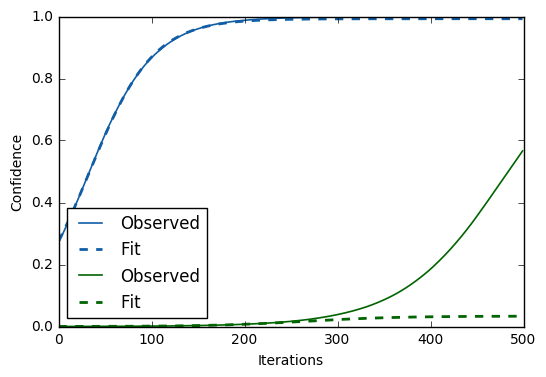

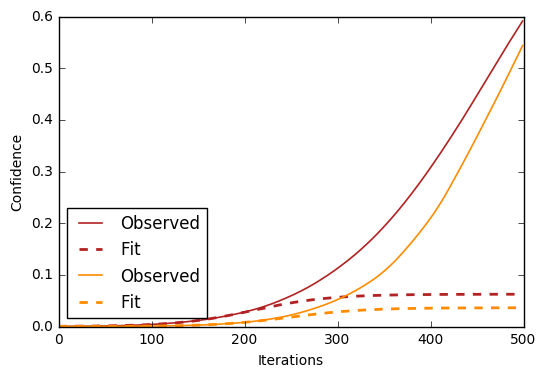

In [5]:
if False:
    for index in range(10):
        fig, (ax0, ax1) = ppt.subplots(ncols=2, figsize=(16, 4))
        ax0.plot(success_curves[index], label='Observed', color='#115EA6', linewidth=1.2)
        ax0.plot(success_predictions[index], label='Fit', color='darkgreen', linewidth=1.2)
        ax0.legend(loc='lower left')

        ax1.plot(failure_curves[index], label='Observed', color='#115EA6', linewidth=1.2)
        ax1.plot(failure_predictions[index], label='Fit', color='darkgreen', linewidth=1.2)
        ax1.legend(loc='lower left')

def plot(indices, colors):
    fig = ppt.figure()
    color_iter = iter(colors)
    for i in indices:
        c = next(color_iter)
        ppt.plot(success_curves[i], label='Observed', color=c, linewidth=1.2, linestyle='-')
        ppt.plot(success_predictions[i], label='Fit', color=c, linewidth=2, linestyle='--')
        ppt.xlabel('Iterations')
        ppt.ylabel('Confidence')
        ppt.legend(loc='lower left')
    return fig

success_colors = ('#115EA6', 'darkgreen')
success_plot_indices = (0, 1)
fig = plot(success_plot_indices, success_colors)
fig.savefig(SAVE_PATH_PREFIX + '-success.png', bbox_inches='tight')

failure_colors = ('firebrick', 'darkorange', 'mediumorchid')
failure_plot_indices = (3, 4)
fig = plot(failure_plot_indices, failure_colors)
fig.savefig(SAVE_PATH_PREFIX + '-failure.png', bbox_inches='tight')